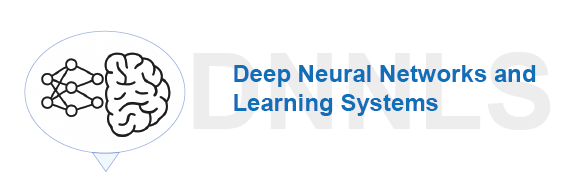

# Week 7: Text encoders - Main Notebook

**Introduction:**
In this notebook we will continue working on our assessment task. Our goal today is to learn how to use text encoders and how to use them to create self supervision tasks in our dataset. Remember that in the end, we only need the **embeddings** for our final assessment: We will process them in future exercises to be able to process the whole sequence of scenes in the dataset.

This time however, we will use the fact that the dataset has additional tags: Objects, Actions and People to create additional self-suppervised tasks to improve the quality of our representations.

**Learning objectives:**

- Use text encoders to label data automatically
- Learn to align multi-modal embeddings
- Visualize and evaluate the quality of the embeddings
---


# **Lab session**

## Loading the data

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

from datasets import load_dataset
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import numpy as np

# This function just extracts the tags from the text, don't get distracted by it.
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data"""
    soup = BeautifulSoup(text, 'html.parser')
    images = []

    for gdi in soup.find_all('gdi'):
        # Debug: print what BeautifulSoup sees
        # print(f"GDI tag attributes: {gdi.attrs}")
        # print(f"GDI tag string: {str(gdi)[:100]}...")

        # Method 1: Try to get image attribute directly
        image_id = None
        if gdi.attrs:
            # Check for attributes like 'image1', 'image2', etc.
            for attr_name, attr_value in gdi.attrs.items():
                if 'image' in attr_name.lower():
                    image_id = attr_name.replace('image', '')
                    break

        # Method 2: Extract from the tag string using regex
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r'<gdi\s+image(\d+)', tag_str)
            if match:
                image_id = match.group(1)

        # Method 3: Fallback - use sequential numbering
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        # Extract tagged elements
        objects = re.findall(r'<gdo[^>]*>(.*?)</gdo>', str(gdi))
        actions = re.findall(r'<gda[^>]*>(.*?)</gda>', str(gdi))
        locations = re.findall(r'<gdl[^>]*>(.*?)</gdl>', str(gdi))

        images.append({
            'image_id': image_id,
            'description': content,
            'objects': objects,
            'actions': actions,
            'locations': locations,
            'raw_text': str(gdi)
        })

    return images


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

## Exploration

Do a little bit of exploration on these tags.

1. Plot the associated image
2. Print the full description
3. Print the different tags.

Check how they fit with what you see in the image

In [2]:
for i in range(5):
  image_data = parse_gdi_text(train_dataset['story'][i])

  print(image_data[i]['objects'])
  print(image_data[i]['actions'])

['cardboard boxes', 'a blue blanket', 'a table', 'James', 'James', 'James']
['enters', 'enters', 'looks around']
['John', 'Alex', 'Mike', 'Sarah', 'buildings', 'John', 'He', 'them', 'he', 'them', 'he', 'wall', 'him', 'his']
[]
['John', 'Sarah', 'Emily', 'David', 'Alex', 'John', 'Sarah', 'Emily', 'David', 'Alex', 'John', 'Wall']
['walked', 'led', 'followed', 'tried']
['Lady Isolde', 'She', 'Lady Elara', 'she', 'She', 'Lady Elara', 'Sir Cedric', 'She', 'chair', 'her', 'her']
['stood', 'believed', 'was']
['John', 'William', 'Robert', 'Michael', 'James', 'Thomas', 'Peter', 'David', 'Andrew', 'Richard', 'walls', 'they', 'their', 'John', 'his', 'him', 'John', 'John']
[]


In [3]:
def plot_image_with_text(image, text,figsize = (10,8)):
  fig = plt.figure(figsize = figsize, constrained_layout = True)
  gs = fig.add_gridspec(2,1, height_ratios = [0.8,0.2])

  ax_image =fig.add_subplot(gs[0])
  ax_image.imshow(image)
  ax_image.axis("off")
  ax_image.set_title("Image", fontsize = 13, pad =10)

  ax_text = fig.add_subplot(gs[1])
  ax_text.axis("off")
  ax_text.text(0,1,text,transform = ax_text.transAxes, fontsize = 10, verticalalignment = 'top', wrap = True, fontfamily = 'monospace')
  plt.tight_layout()
  plt.show()

In [4]:
k = 9
d = train_dataset[k]
frame_count = d['frame_count']
frames = d ['images']

for i in range(int(frame_count)):
  image_pil = frames[i]
  image_np = np.array(image_pil)
  story = d['story']
  parsed_image_descr = parse_gdi_text(story)
  #plot_image_with_text(image_np,parsed_image_descr[i]["description"])

Create a text encoder

In [5]:
!pip install transformers

## Create a text encoder [NEW CONTENT!]

**Purpose**: We will use CLIP to convert text descriptions to 64D embeddings for training visual encoder. Initially the original CLIP embeddings have 512D but we add a new layer to get smaller, more manageable sizes

**Key Features**:
- Frozen CLIP text backbone (openai/clip-vit-base-patch32)
- Trainable linear projection: 512D → 64D
- Automatic tokenization with truncation (max 77 tokens)
- Device-aware (CPU/GPU)


In [6]:

import torch
from transformers import AutoTokenizer, CLIPTextModelWithProjection
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_embedding_size = 64

class ClipTextEncoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
      self.tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

      # We don't want to train the pretrained model. This freezes the model
      for param in self.model.parameters():
            param.requires_grad = False
      self.model.eval()

      self.reduction_layer = nn.Linear(self.model.config.projection_dim, text_embedding_size)

    def forward(self, text):
      embedding = self.encode(text)
      return self.reduction_layer(embedding)

    def encode(self, text):
      inputs = self.tokenizer(text, padding=True, return_tensors="pt", truncation=True,
            max_length=77 )
      # We need to do this so that all the inputs are in the same device
      inputs = {key: value.to(device) for key, value in inputs.items()}

      with torch.no_grad():
        # The "**" unpacks the dictionary. Do some tests to understand it.
        outputs = self.model(**inputs)

      return outputs.text_embeds


# Do some tests if you want
# text_encoder = ClipTextEncoder()
# text_encoder.encode(image_data[0]['actions']).shape

## Visual Encoder

**Purpose**: Converts images to text-compatible embeddings for cross-modal learning. We will reuse the simple encoder from last week.

**Architecture**:
- **Feature Extraction**: 3-layer CNN (16→32→64 channels) with ReLU activations and pooling
- **Embedding Network**: Flatten → 128D dense layer
- **Prediction Head**: 64D output (matches text encoder dimension)

**Input**: Image tensor `[batch_size, 3, x, x]` - x = 224 but thanks to the adaptive layer, we can use other sizes.
**Output**: Tuple `(intermediate_features, text_embeddings)`
- `intermediate_features`: 128D vector for analysis
- `text_embeddings`: 64D vector optimized to match CLIP text embeddings

**Training**: Note that we will have to use a new loss. More on this later but, for now, the goal will be to minimize cosine distance between visual and text embeddings.

In [7]:
import torch.nn as nn # Layer
import torch.nn.functional as F # functions

class VisualEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=11, padding=1) # 16x226x226
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.AdaptiveAvgPool2d((4,4)) # 64x4x4

        self.feature_block = nn.Sequential(self.conv1,
                                         nn.ReLU(),
                                         self.pool1,
                                         self.conv2,
                                         nn.ReLU(),
                                         self.pool2,
                                         self.conv3,
                                         nn.ReLU(),
                                         self.pool3)

        # Embeddings
        self.embedding = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
        )

        # Task Head
        self.object_head = nn.Sequential(
            nn.Linear(128, text_embedding_size)
        )

    def forward(self, x):
      # Same as before
      x = self.feature_block(x)
      x = torch.flatten(x, start_dim=1)
      x = self.embedding(x)
      predicted_object = self.object_head(x)
      return x, predicted_object

# Do some tests...

## Create datamanager

### Task Overview
**Cross-Modal Visual-Text Embedding Learning**

The dataset prepares image-text pairs for training a visual encoder to predict text embeddings. The model learns to generate image embeddings that are semantically similar to CLIP text embeddings of object descriptions.

### Data Flow

#### Input Structure
Each dataset item contains:
- **Multiple video frames** (`images`)
- **Frame annotations** (`story` parsed into `image_attributes`)
- **Object descriptions** per frame (`objects` list)

#### Processing Pipeline
1. **Frame Selection**: Randomly select one frame from available frames
2. **Image Preprocessing**:
   - Random resized crop (224×224) for augmentation
   - Tensor conversion (H×W×C → C×H×W)
   - ImageNet normalization (pre-trained weights compatibility)
3. **Text Processing**:
   - Extract object labels for selected frame
   - Join objects with commas into single string
   - Convert to lowercase for consistency

#### Output Format
- **Image Tensor**: `[3, 224, 224]` - Preprocessed RGB image
- **Text Label**: String - Comma-separated object descriptions

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms

class TextClassificationTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.ToTensor(), # HxWxC -> CxHxW
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])



    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]
      self.image_attributes = parse_gdi_text(self.dataset[idx]["story"])

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the neural netwokr

      objects = self.image_attributes[frame_idx]["objects"]

      return input_frame, ','.join(objects).lower() # x, y


my_dataset = TextClassificationTaskDataset(train_dataset) # Instantiate the dataset

# Do some tests
# image, text = my_dataset[0]
# print(text)

my_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=True) # Instantiate the dataloader
# Do some tests
# images, text = next(iter(my_dataloader))
# print(text)

# Training Procedure

## Objective
This training procedure teaches a visual encoder to produce image embeddings that are semantically similar to text embeddings of object descriptions from the same frame. We will have start becoming a bit more organised, so, this time, we create additional functions to keep things modular.

## Key Components

---

###  Trainable Parameters
- **Visual Encoder**: Full CNN (learns from scratch)
- **Text Encoder**: Only reduction layer (CLIP backbone frozen)

###  Cosine Embedding Loss
- **Formula**: `Loss = 1 - cosine_similarity(visual_emb, text_emb)`
- **Target**: `1` (embeddings should point same direction)
- **Purpose**: Measure semantic similarity, ignore vector magnitude

## Training Flow

---

###  Per Epoch
1. **Process batches** of image-text pairs
2. **Forward pass**:
   - Images → Visual Encoder → 64D embeddings
   - Text → Text Encoder → 64D embeddings
3. **Compute loss**: Cosine similarity between embeddings
4. **Backward pass**: Update visual CNN + text reduction layer

###  Full Training
- **Epochs**: 10 total
- **Checkpoints**: Save every 5 epochs (New technique)
- **Monitoring**: Print loss every 50 batches (Just in case)

## Expected Progress
- **Start**: Loss ~0.9 (random)
- **Mid**: Loss ~0.4-0.6 (learning)
- **End**: Loss ~0.2-0.4 (aligned embeddings)

In [9]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_encoder = ClipTextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)

# Check the sizes
# num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Number of trainable parameters: {num_parameters}")

trainable_params = [
    {'params': visual_encoder.parameters()},
    {'params': text_encoder.reduction_layer.parameters()}
]

optimizer = optim.Adam(trainable_params, lr=1e-4)
# NOTE: COSINE EMBEDDING LOSS
# NEW!!!!!
criterion = nn.CosineEmbeddingLoss()
# !!!!

def train_epoch(visual_encoder, text_encoder, dataloader, optimizer, criterion, device):
    visual_encoder.train()
    text_encoder.train()  # This only affects the reduction layer

    total_loss = 0.0
    num_batches = 0

    for batch_idx, (images, text_labels) in enumerate(dataloader):
        # Move data to device
        images = images.to(device)
        text_labels = list(text_labels)

        # Forward pass through visual encoder
        _, visual_embeddings = visual_encoder(images)  # (batch_size, text_embedding_size)

        # Forward pass through text encoder
        text_embeddings = text_encoder(text_labels)  # (batch_size, text_embedding_size)

        # Create target for cosine embedding loss
        # We want the embeddings to be similar, so target = 1
        target = torch.ones(images.size(0)).to(device)

        # Compute cosine embedding loss
        loss = criterion(visual_embeddings, text_embeddings, target)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')

    return total_loss / num_batches

def train_model(visual_encoder, text_encoder, train_dataloader, num_epochs=10):
  for epoch in range(num_epochs):
      avg_loss = train_epoch(visual_encoder, text_encoder, train_dataloader, optimizer, criterion, device)
      print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

      # Optional: Save checkpoint
      # NEW! This is advisable because the model starts to get big
      if (epoch + 1) % 5 == 0:
          torch.save({
              'epoch': epoch,
              'visual_encoder_state_dict': visual_encoder.state_dict(),
              'text_encoder_reduction_state_dict': text_encoder.reduction_layer.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': avg_loss,
          }, f'checkpoint_epoch_{epoch+1}.pth')

# Start training
print("Starting training...")
train_model(visual_encoder, text_encoder, my_dataloader, num_epochs=10)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Starting training...
Batch 0, Loss: 0.9395
Batch 50, Loss: 0.0818
Batch 100, Loss: 0.0466
Epoch 1/10, Average Loss: 0.1770
Batch 0, Loss: 0.0457
Batch 50, Loss: 0.0319
Batch 100, Loss: 0.0240
Epoch 2/10, Average Loss: 0.0333
Batch 0, Loss: 0.0236
Batch 50, Loss: 0.0213
Batch 100, Loss: 0.0157
Epoch 3/10, Average Loss: 0.0198
Batch 0, Loss: 0.0167
Batch 50, Loss: 0.0147
Batch 100, Loss: 0.0109
Epoch 4/10, Average Loss: 0.0138
Batch 0, Loss: 0.0149
Batch 50, Loss: 0.0120
Batch 100, Loss: 0.0126
Epoch 5/10, Average Loss: 0.0108
Batch 0, Loss: 0.0072
Batch 50, Loss: 0.0065
Batch 100, Loss: 0.0075
Epoch 6/10, Average Loss: 0.0086
Batch 0, Loss: 0.0112
Batch 50, Loss: 0.0093
Batch 100, Loss: 0.0054
Epoch 7/10, Average Loss: 0.0073
Batch 0, Loss: 0.0067
Batch 50, Loss: 0.0056
Batch 100, Loss: 0.0058
Epoch 8/10, Average Loss: 0.0059
Batch 0, Loss: 0.0049
Batch 50, Loss: 0.0054
Batch 100, Loss: 0.0044
Epoch 9/10, Average Loss: 0.0052
Batch 0, Loss: 0.0043
Batch 50, Loss: 0.0037
Batch 100, Loss:

# Exercises

## Exercise 1: Train the Model
**Task**: Run the training procedure and monitor progress.

**What to do**:
- Execute the training code for 10 epochs
- Observe how the loss decreases over time
- Save the trained model checkpoint
- Plot the loss over time

**Expected outcome**:
- Final loss between 0.2-0.4
- Model capable of predicting text embeddings from images

**💡 Hint**: Monitor the loss every 50 batches to see if training is progressing well.

---

## Exercise 2: Visualize Learned Features
**Task**: Plot the convolutional filters to understand what the model learned.

**What to do**:
- Access filters from `visual_encoder.conv1.weight` and `visual_encoder.conv3.weight`
- Normalize filter values for visualization
- Plot first 16 filters from each layer in a 4x4 grid
- For conv1 (RGB input), show all 3 channels as color image
- For conv3, take mean across input channels and use colormap

**Expected outcome**:
- Grid of 16 conv1 filters showing edge detectors and color patterns
- Grid of 16 conv3 filters showing more complex feature detectors

**💡 Hint**: Use `model.conv1.weight.data.cpu().numpy()` to get filter values and `plt.subplots(4, 4)` for grid layout.

---
## Exercise 3: Create Feature Map Visualization Function  
**Task**: Implement `visualize_feature_maps()` to see how images activate different channels.

**What to do**:
- Manually pass a sample image through conv1 and conv3 layers
- Extract and normalize the output feature maps
- Plot first 16 feature maps from each layer
- Compare how different channels respond to image content

**Expected outcome**:
- Feature maps showing what each channel detects in the image
- conv1 maps: Simple edges and colors
- conv3 maps: Complex patterns and object parts

**💡 Hint**: Use `model.conv1(sample_image)` to get feature maps, then take `[0]` for first batch item.

---

## Exercise 4: Embedding Space Analysis
**Task**: Analyze the embedding space using PCA on full-size images (no cropping).

**What to do**:
1. Modify the dataset to use full images instead of cropped ones
2. Extract embeddings from trained model
3. Use PCA to project 64D embeddings to 2D for visualization
4. Color points by object categories

**Expected outcome**:
- 2D plot showing clustering of similar objects
- Insights about how the model organizes visual concepts

**💡 Hint**: Remove `RandomResizedCrop` from transforms and use `Resize(224)` instead.

---

## Exercise 5: Multi-Head Architecture
**Task**: Extend the model with separate heads for objects and actions.

**What to do**:
1. Add a second head to `VisualEncoder` for action prediction
2. Modify the dataset to provide both object and action labels
3. Use a combined loss function (object_loss + action_loss)

**Expected outcome**:
- Model that predicts both WHAT objects are present and WHAT actions are happening
- Better semantic understanding of scenes

**💡 Hint**: Add `self.action_head = nn.Linear(128, text_embedding_size)` and return both embeddings.

## Visualizing the resulting filters

=== Conv1 Filters (16 filters, 3 input channels) ===


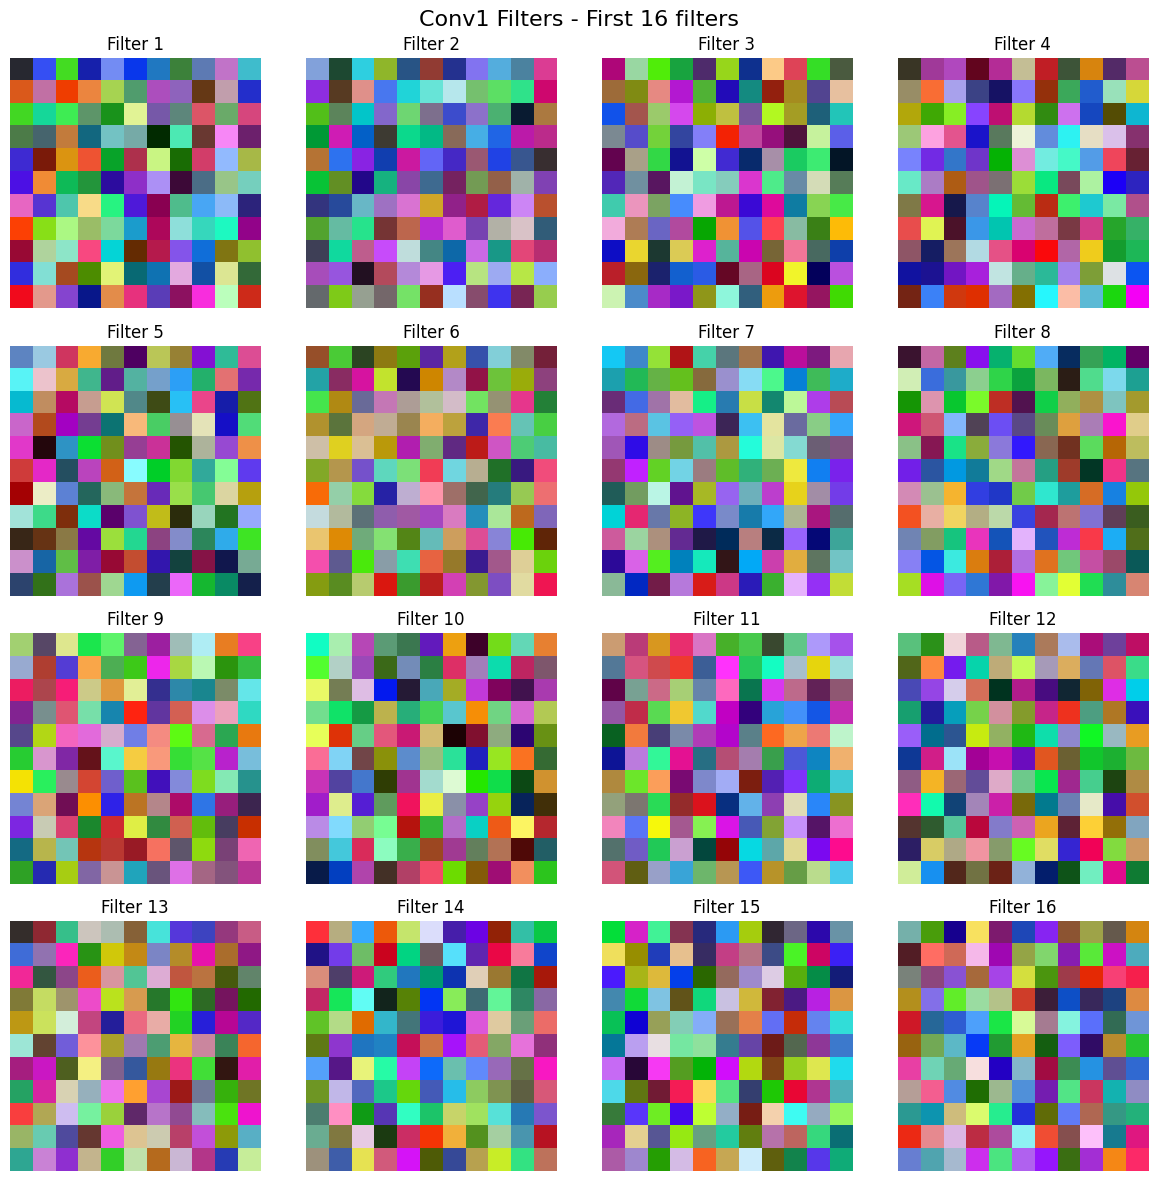

=== Conv3 Filters (first 16 of 64 filters) ===


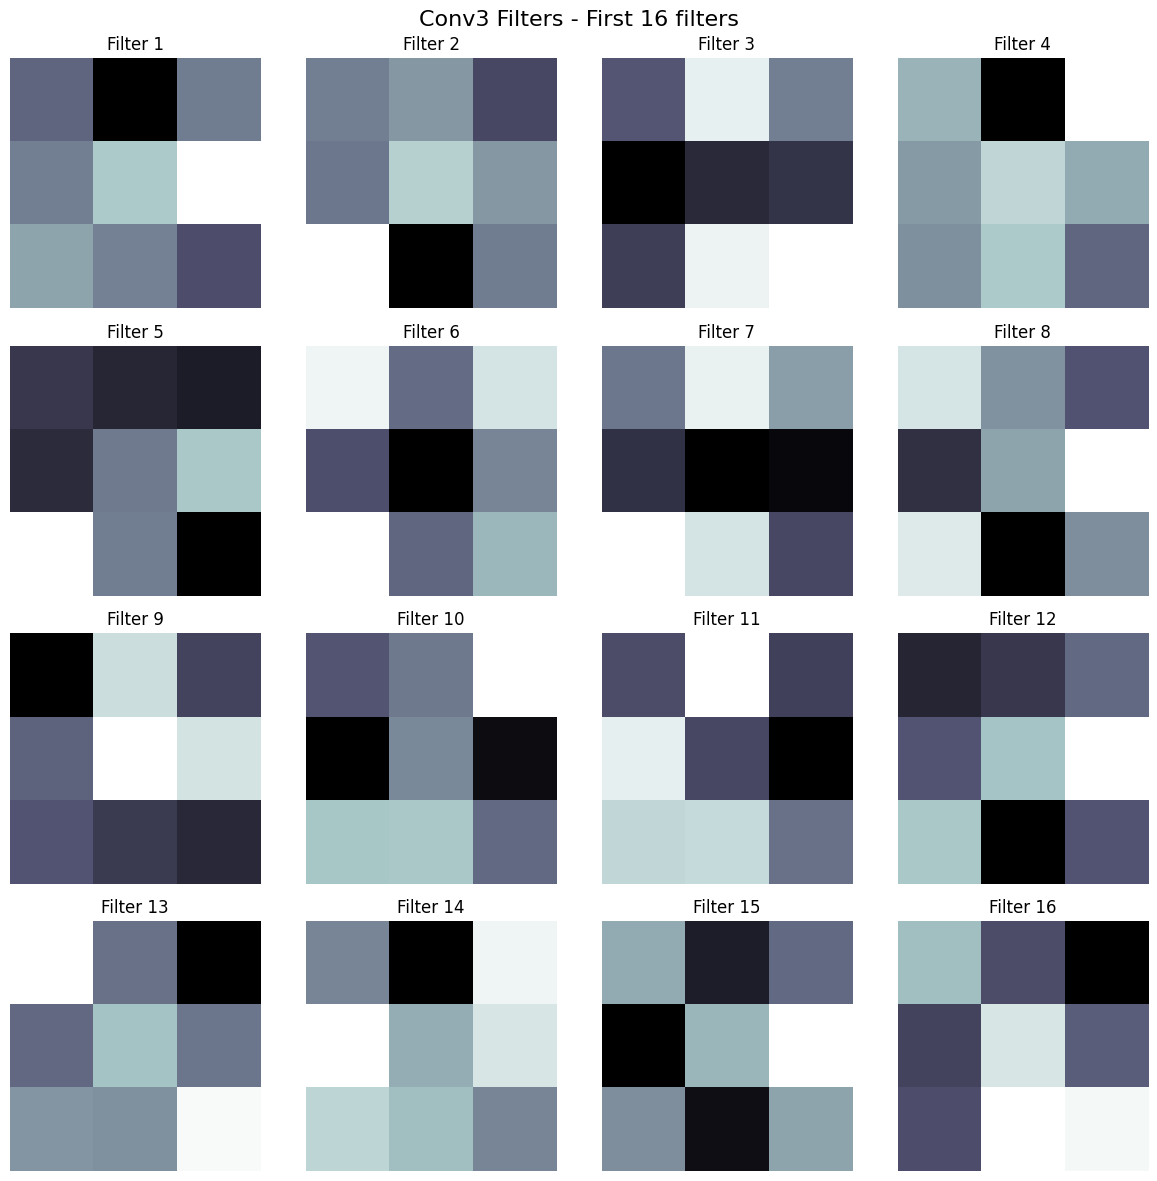

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_filters_simple(model):
    """Simple visualization of conv1 and conv3 filters"""

    # Get weights from conv1 and conv3
    conv1_weights = model.conv1.weight.data.cpu().numpy()  # Shape: (16, 3, 11, 11)
    conv3_weights = model.conv3.weight.data.cpu().numpy()  # Shape: (64, 32, 3, 3)

    # Visualize conv1 filters (first layer - RGB filters)
    print("=== Conv1 Filters (16 filters, 3 input channels) ===")
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Conv1 Filters - First 16 filters', fontsize=16)

    for i in range(16):
        ax = axes[i//4, i%4]
        # For RGB filters, take the mean across input channels or show RGB
        filter_rgb = conv1_weights[i]  # Shape: (3, 11, 11)

        # Normalize each filter for visualization
        filter_rgb = (filter_rgb - filter_rgb.min()) / (filter_rgb.max() - filter_rgb.min())

        # Convert from (3, 11, 11) to (11, 11, 3) for matplotlib
        filter_rgb = np.transpose(filter_rgb, (1, 2, 0))
        ax.imshow(filter_rgb, cmap='gray')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Visualize conv3 filters (show first 16 of 64 filters)
    print("=== Conv3 Filters (first 16 of 64 filters) ===")
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Conv3 Filters - First 16 filters', fontsize=16)

    for i in range(16):
        ax = axes[i//4, i%4]
        # For conv3, take mean across input channels (32 channels)
        filter_img = conv3_weights[i].mean(axis=0)  # Shape: (3, 3)

        # Normalize
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())

        ax.imshow(filter_img, cmap='bone')
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_filters_simple(visual_encoder)

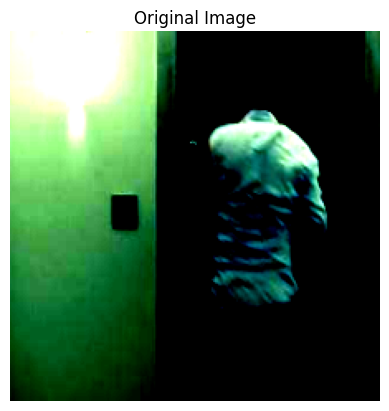

=== Conv1 Feature Maps (first 16 channels) ===


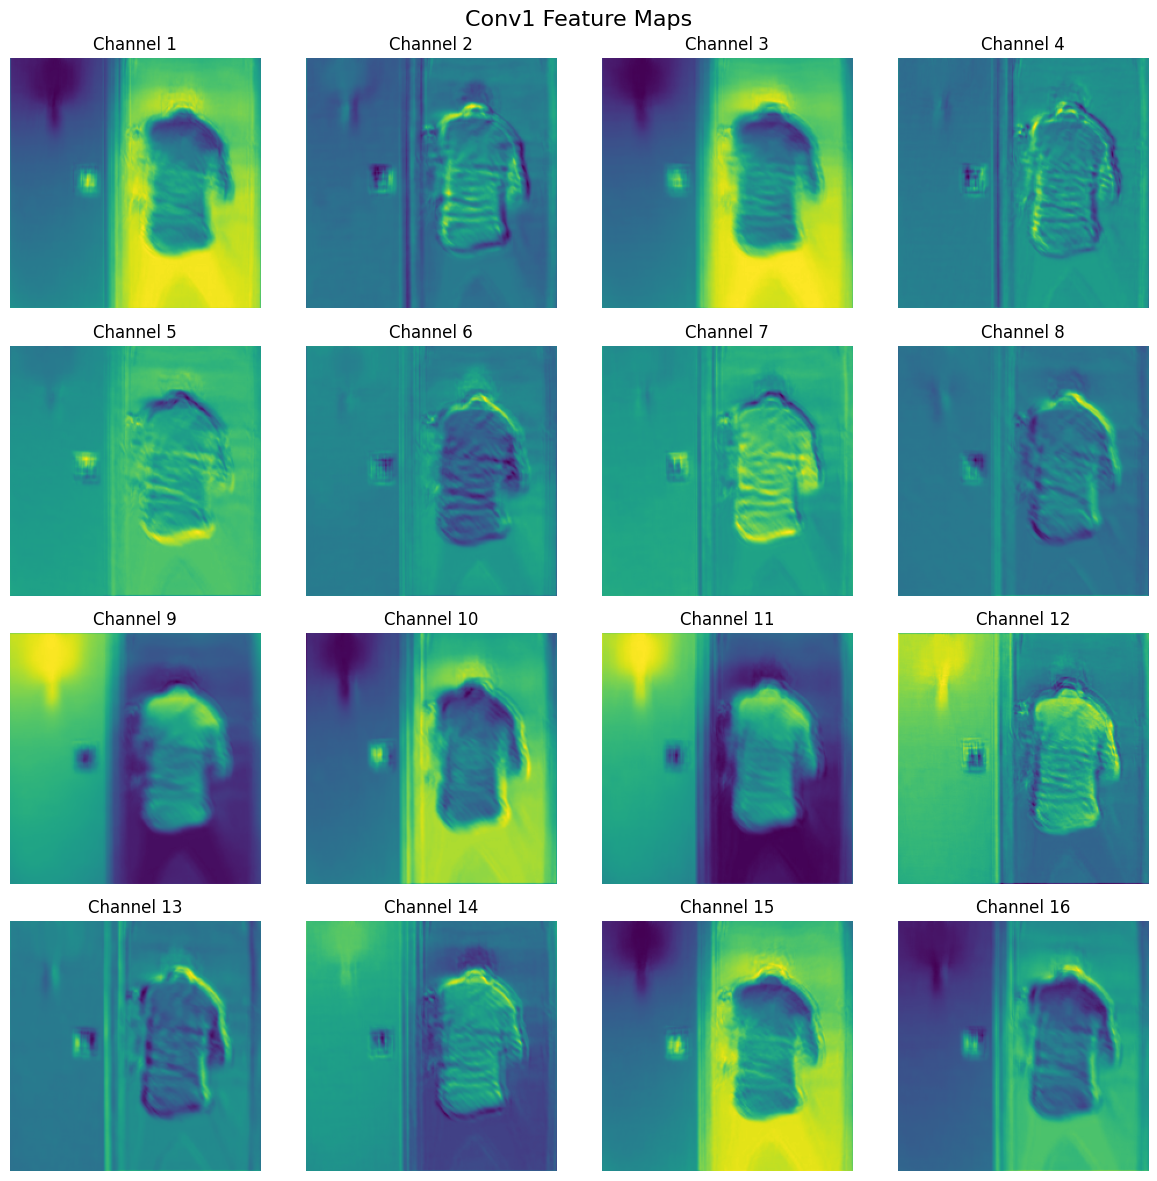

=== Conv3 Feature Maps (first 16 channels) ===


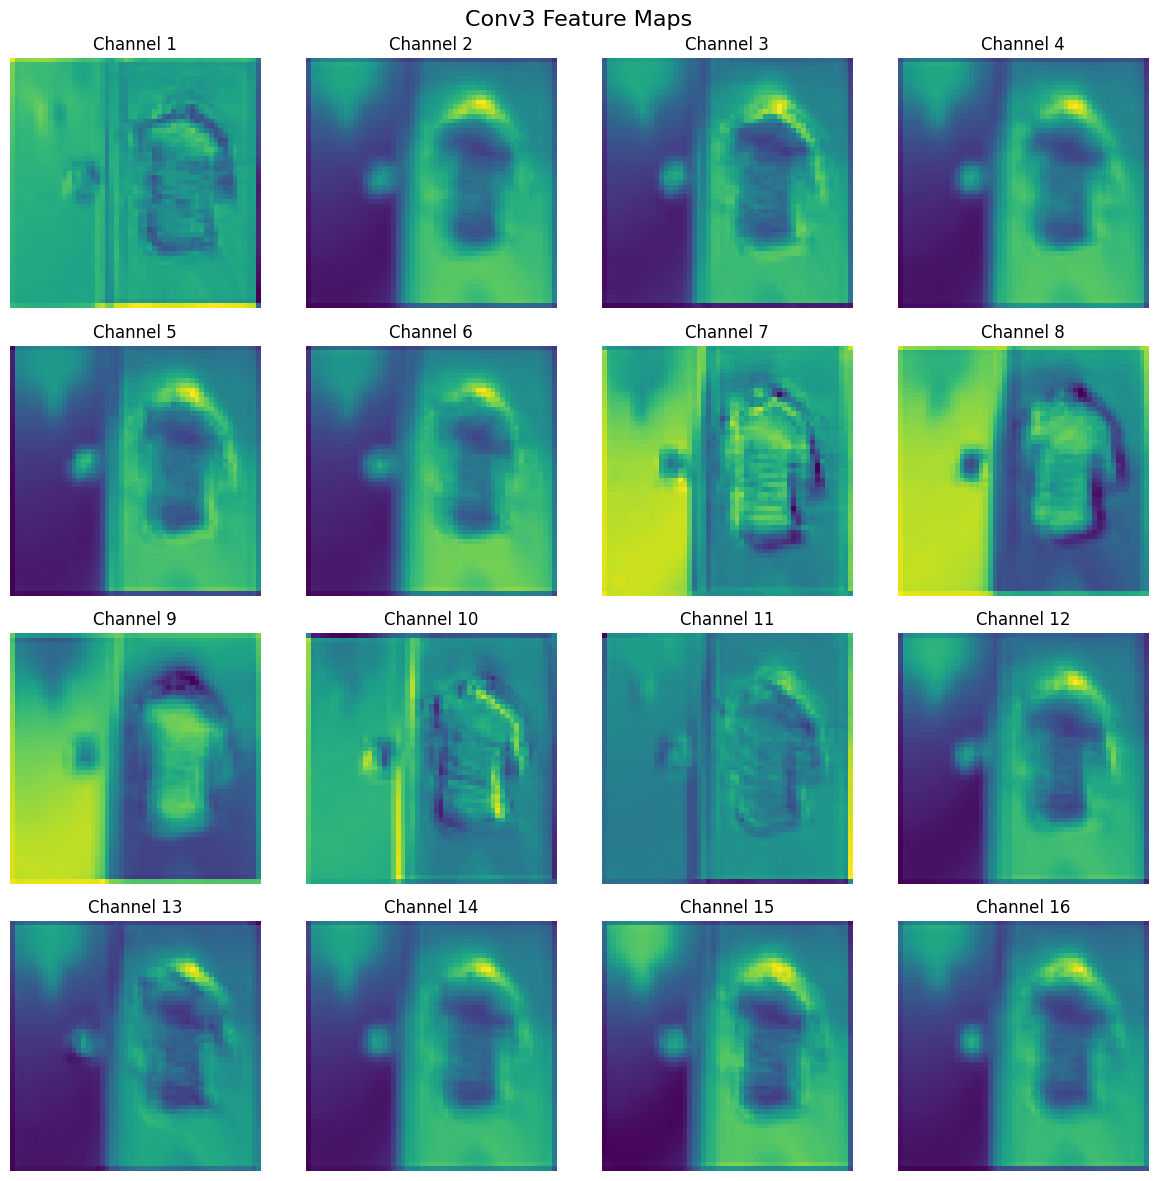

Conv1 feature maps shape: (16, 216, 216)
Conv3 feature maps shape: (64, 53, 53)
Conv1 feature maps range: [-3.713, 2.913]
Conv3 feature maps range: [-1.364, 2.701]


In [11]:
def visualize_feature_maps_simple(model, sample_image):
    """Simple visualization of feature maps by manually running through layers"""

    model.eval()

    with torch.no_grad():
        if sample_image.dim() == 3:
            sample_image = sample_image.unsqueeze(0)  # Add batch dimension

        # Manually pass through conv1
        conv1_out = model.conv1(sample_image)
        relu1_out = torch.relu(conv1_out)
        pool1_out = model.pool1(relu1_out)

        # Pass through conv2
        conv2_out = model.conv2(pool1_out)
        relu2_out = torch.relu(conv2_out)
        pool2_out = model.pool2(relu2_out)

        # Pass through conv3
        conv3_out = model.conv3(pool2_out)
        relu3_out = torch.relu(conv3_out)
        pool3_out = model.pool3(relu3_out)

    # Convert to numpy for visualization
    conv1_maps = conv1_out[0].cpu().numpy()  # First batch item
    conv3_maps = conv3_out[0].cpu().numpy()  # First batch item

    # Visualize conv1 feature maps (first 16 channels)
    print("=== Conv1 Feature Maps (first 16 channels) ===")
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Conv1 Feature Maps', fontsize=16)

    for i in range(16):
        ax = axes[i//4, i%4]
        feature_map = conv1_maps[i]

        # Normalize for visualization
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

        ax.imshow(feature_map, cmap='viridis')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Visualize conv3 feature maps (first 16 channels)
    print("=== Conv3 Feature Maps (first 16 channels) ===")
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Conv3 Feature Maps', fontsize=16)

    for i in range(16):
        ax = axes[i//4, i%4]
        feature_map = conv3_maps[i]

        # Normalize for visualization
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())

        ax.imshow(feature_map, cmap='viridis')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Conv1 feature maps shape: {conv1_maps.shape}")
    print(f"Conv3 feature maps shape: {conv3_maps.shape}")
    print(f"Conv1 feature maps range: [{conv1_maps.min():.3f}, {conv1_maps.max():.3f}]")
    print(f"Conv3 feature maps range: [{conv3_maps.min():.3f}, {conv3_maps.max():.3f}]")

# Get a sample image and visualize
sample_image, _ = my_dataset[0]
# Original image
plt.imshow(sample_image.permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')
plt.show()
visualize_feature_maps_simple(visual_encoder, sample_image.to(device))

## Visualizing the embeddings

Explained variance ratio: [9.977487e-01 2.937899e-04]


/tmp/ipython-input-1100120690.py:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


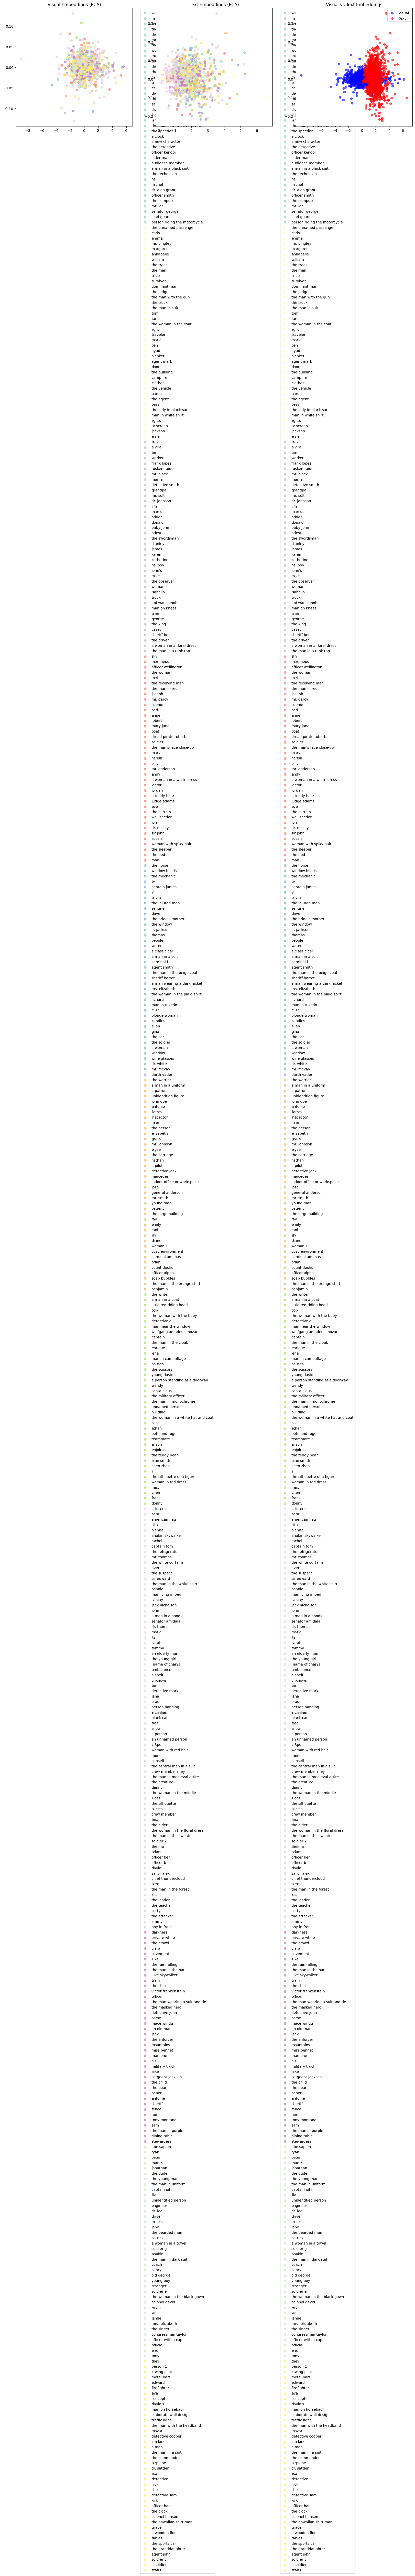

In [12]:
from sklearn.decomposition import PCA

def visualize_embeddings_pca(visual_encoder, text_encoder, dataloader, device, num_samples=1000):
    """Visualize embeddings using PCA"""
    visual_encoder.eval()
    text_encoder.eval()

    visual_embeddings = []
    text_embeddings = []
    labels = []

    with torch.no_grad():
        for i, (images, text_labels) in enumerate(dataloader):
            if i * images.size(0) >= num_samples:
                break

            images = images.to(device)

            if isinstance(text_labels, tuple):
                text_list = list(text_labels)
            else:
                text_list = text_labels

            # Get embeddings
            _, visual_embeds = visual_encoder(images)
            text_embeds = text_encoder(text_list)

            visual_embeddings.append(visual_embeds.cpu().numpy())
            text_embeddings.append(text_embeds.cpu().numpy())

            # Use first word as label for coloring
            batch_labels = [text.split(',')[0] if text else 'unknown' for text in text_list]
            labels.extend(batch_labels)

    # Concatenate all embeddings
    visual_embeddings = np.vstack(visual_embeddings)
    text_embeddings = np.vstack(text_embeddings)

    # Apply PCA
    pca = PCA(n_components=2)
    visual_2d = pca.fit_transform(visual_embeddings)
    text_2d = pca.transform(text_embeddings)  # Use same PCA transformation

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Create visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Plot visual embeddings
    unique_labels = list(set(labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        mask = [l == label for l in labels]
        ax1.scatter(visual_2d[mask, 0], visual_2d[mask, 1],
                   c=[colors[i]], label=label, alpha=0.7)

    ax1.set_title('Visual Embeddings (PCA)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot text embeddings
    for i, label in enumerate(unique_labels):
        mask = [l == label for l in labels]
        ax2.scatter(text_2d[mask, 0], text_2d[mask, 1],
                   c=[colors[i]], label=label, alpha=0.7)

    ax2.set_title('Text Embeddings (PCA)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot both together
    ax3.scatter(visual_2d[:, 0], visual_2d[:, 1], c='blue', label='Visual', alpha=0.6)
    ax3.scatter(text_2d[:, 0], text_2d[:, 1], c='red', label='Text', alpha=0.6)
    ax3.set_title('Visual vs Text Embeddings')
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return visual_2d, text_2d, labels

# Usage
visual_2d, text_2d, labels = visualize_embeddings_pca(
    visual_encoder, text_encoder, my_dataloader, device
)

**Bonus exercise: ** Use a different encoder.

In [13]:
from sentence_transformers import SentenceTransformer

class SentenceTextEncoder:
    def __init__(self):
        self.model = SentenceTransformer('all-mpnet-base-v2')

    def preprocess_tags(self, text):
        # Clean and normalize tags
        tags = re.findall(r'[A-Za-z]+', text)  # Extract words
        return ' '.join(tags).lower()

    def encode(self, text):
        cleaned_text = text
        return self.model.encode(cleaned_text)

In [14]:
train_dataset

Dataset({
    features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
    num_rows: 3552
})